In [25]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [26]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [27]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

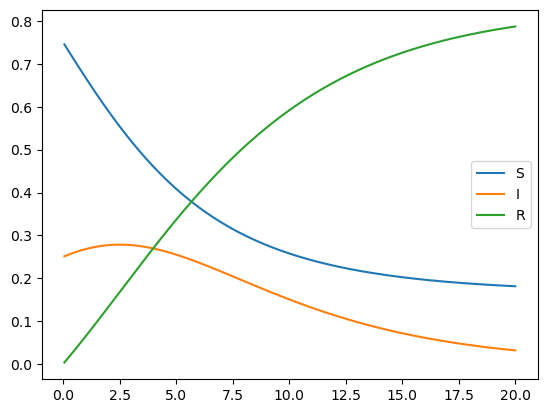

In [28]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [29]:
# build model and fit it
method = 'euler'
step_size = 2*dt
# build model and fit it
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

In [30]:
train_beta = torch.tensor([1.35e-7,1.26e-7,5.24e-7,7.92e-10,1.51e-7,5.74e-10,1.23e-7,2.62e-9,3.08e-10])
log_train_beta = torch.log10(train_beta)
train_delta = torch.tensor([0.61,0.81,0.51,1.21,2.01,0.81,0.91,1.61,2.01])
#train_p = torch.tensor([0.2,0.2,0.2,361.6,0.2,382,0.2,278.2,299])
#log_train_p = torch.log10(train_p)
train_p = torch.tensor([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
train_c = 2.4*torch.ones(9)

#train_params = torch.tensor([torch.mean(log_train_beta),torch.mean(train_delta),torch.mean(log_train_p),torch.mean(train_c)])
train_params = torch.cat((torch.mean(log_train_beta)*torch.ones(num_hosts),torch.mean(train_delta)*torch.ones(num_hosts),torch.mean(train_p)*torch.ones(num_hosts),torch.mean(train_c)*torch.ones(num_hosts)))

com_train = torch.cat((SIR_train_data[1,:],0.01*train_params))

In [31]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    # print(SIR_est)
    UIV_x0_est = model.nUIV_x0
    #UIV_x0_est = UIV_x0_est.T
    #UIV_U0_est = UIV_x0_est[::3]
    #UIV_I0_est = UIV_x0_est[1::3]
    #UIV_V0_est = UIV_x0_est[2::3]
    #com_est = torch.cat((SIR_est[1,:],1/5*torch.log10(UIV_U0_est),1/5*UIV_I0_est,1/5*torch.log10(UIV_V0_est)),dim=0)

    beta_est = model.nUIV_dynamics.betas
    log_beta_est = torch.log10(beta_est)
    delta_est = model.nUIV_dynamics.deltas
    p_est = model.nUIV_dynamics.ps
    log_p_est = torch.log10(p_est)
    c_est = model.nUIV_dynamics.cs

    #params_est = torch.tensor([torch.mean(log_beta_est),torch.mean(delta_est),torch.mean(log_p_est),torch.mean(c_est)])
    params_est = torch.cat((log_beta_est,delta_est,p_est,c_est))
    
    # print("UIV est", UIV_x0_est[3::3])
    com_est = torch.cat((SIR_est[1,:], 0.01*params_est))
    # print(SIR_est[1,:])

    loss = loss_function(com_est, com_train.to(device))
    #loss = loss_function(SIR_est, SIR_train_data.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')
    # break

Epoch 0, loss value: 5.600976943969727.
Epoch 1, loss value: 2.8516721725463867.
Epoch 2, loss value: 3.344050407409668.
Epoch 3, loss value: 3.466357469558716.
Epoch 4, loss value: 3.5083167552948.
Epoch 5, loss value: 3.5181422233581543.
Epoch 6, loss value: 3.496711492538452.
Epoch 7, loss value: 3.4195847511291504.
Epoch 8, loss value: 3.3103253841400146.
Epoch 9, loss value: 3.2419185638427734.
Epoch 10, loss value: 3.2103748321533203.
Epoch 11, loss value: 3.1484241485595703.
Epoch 00013: reducing learning rate of group 0 to 5.0000e-02.
Epoch 12, loss value: 3.012603282928467.
Epoch 13, loss value: 2.7960517406463623.
Epoch 14, loss value: 2.715801239013672.
Epoch 15, loss value: 2.5958468914031982.
Epoch 16, loss value: 2.3177695274353027.
Epoch 17, loss value: 2.012305736541748.
Epoch 18, loss value: 1.8389040231704712.
Epoch 19, loss value: 1.7563047409057617.
Epoch 20, loss value: 1.7387009859085083.
Epoch 21, loss value: 1.7211476564407349.
Epoch 22, loss value: 1.6853796243

In [32]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}, Gradient: {param.grad}")


nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

Parameter name: nUIV_dynamics.parametrizations.betas.original, Gradient: tensor([-0.0193,  0.2745,  0.0311, -0.0518, -0.0107,  0.1332,  0.0027,  0.1446,
        -0.0389,  0.0026, -0.3209,  0.0085,  0.0223, -0.3819, -0.0350,  0.0208,
        -0.2105,  0.1530, -0.0264, -0.2756,  0.0812, -0.3397, -0.0475, -0.0203,
         0.1560, -0.0921,  0.1410, -0.0996,  0.0651,  0.0028, -0.4475, -0.2015,
        -0.1137, -0.2059,  0.0079,  0.0322,  0.2919, -0.0077,  0.0595, -0.0452,
         0.0220,  0.2073,  0.0079,  0.3246, -0.0526, -0.0061, -0.0230, -0.0102,
         0.0212,  0.2315])
Parameter name: nUIV_dynamics.parametrizations.deltas.original, Gradient: tensor([-2.5216e-04, -6.9303e-07, -2.6123e-04, -2.5670e-04,  1.9912e-03,
        -1.9467e-04,  5.0554e-04,  2.7525e-04,  2.8395e-04,  3.0953e-04,
        -2.5298e-04, -2.3310e-04, -2.4498e-04,  4.9121e-05, -1.6888e-06,
         3.5898e-05,  3.7300e-04, -4.6729e-06, -2.6003e-04, -2.6456e-04,
        -1.8734e-04,  1.2669e-04, -7.2162e-06, -7.1143

Resetting to stored initial state.
Resetting to t=0.0.


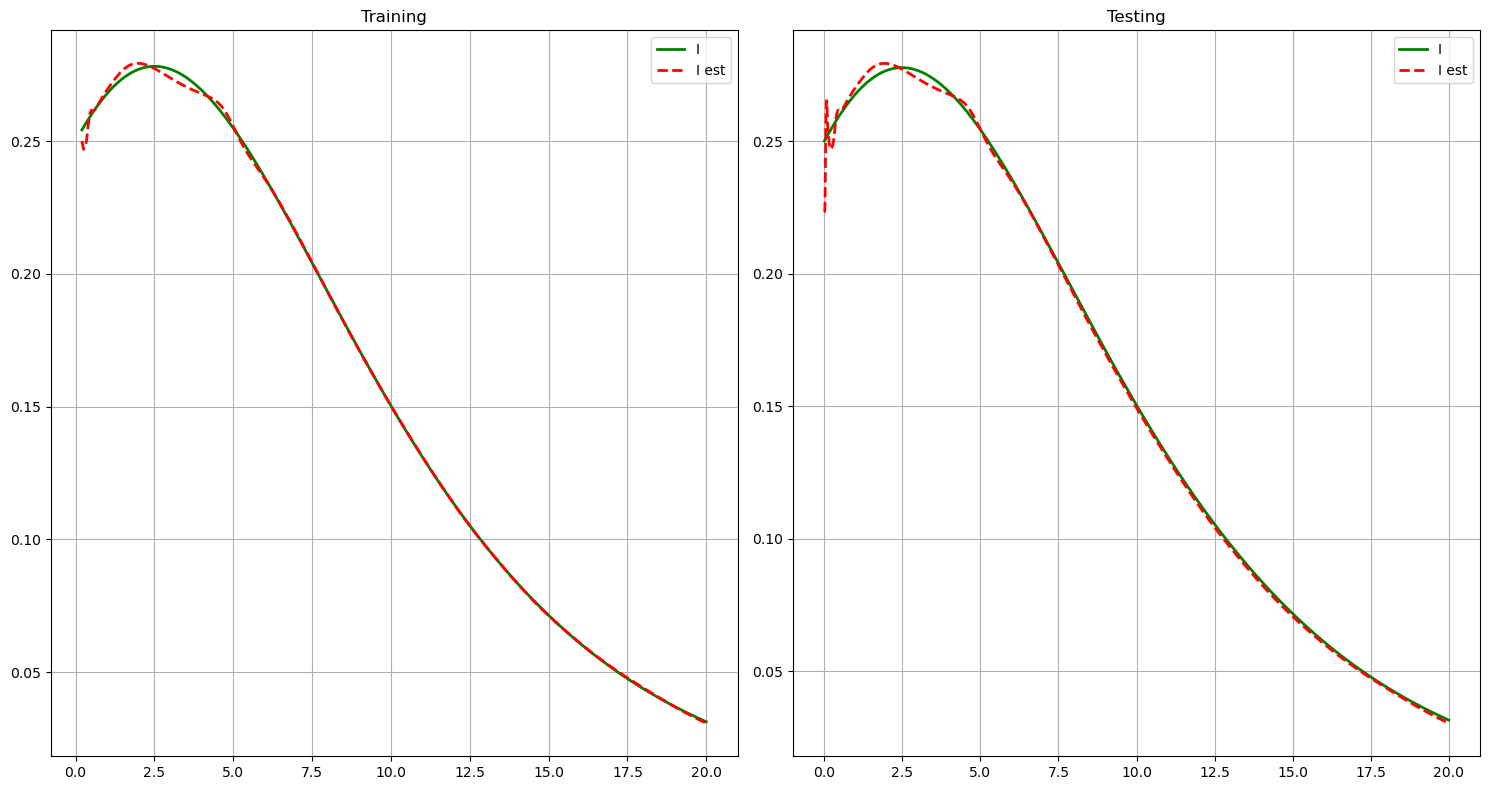

[0.22375704 0.22370045 0.22364663 0.22359638 0.22355059 0.2235104
 0.22347711 0.2234523  0.22343786 0.22343606]
[0.22375704 0.25844115 0.2560673  0.2500822  0.24693424 0.2477631
 0.25052097 0.25627223 0.26028794 0.26170048]


In [33]:
# TODO: Write testing block to visualize the quality of the fit ODE
# First, reset the SIR model, change its time step
SIR_stepper.reset()
SIR_stepper.dt = 0.001
num_steps = 20000
SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']
'''
for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
'''
# np.save("train_time.np", time_train_data)
# np.save("test_time.np", time_test_data)
# np.save("train_est.np", SIR_train_data_est)
# np.save("test_est.np", SIR_test_data_est)
ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
f.tight_layout()
path = './tmp/'
# path = '/content/tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

print(SIR_test_data_est[1, :10])
print(SIR_train_data_est[1, :10])